### Import dependcies

In [3]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import tensorflow as tf

In [4]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout, Activation
from tensorflow.keras.layers import LSTM, GRU
from sklearn.metrics import mean_squared_error
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from sklearn.metrics import mean_squared_error
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from sklearn.preprocessing import MinMaxScaler

### Read the data

In [2]:
stock_data= pd.read_csv('/Users/nsund/Desktop/tensorflow/dataset/nyse/prices.csv')

In [ ]:
stock_data= pd.read_csv('nyse/prices.csv')

In [3]:
stock_data.head(2)

,date,symbol,open,close,low,high,volume
0,2016-01-05 00:00:00,WLTW,123.430000,125.839996,122.309998,126.250000,2163600.0
1,2016-01-06 00:00:00,WLTW,125.239998,119.980003,119.940002,125.540001,2386400.0


In [4]:
stock_data.dtypes

date       object
symbol     object
open      float64
close     float64
low       float64
high      float64
volume    float64
dtype: object

### Check for missing values and range

In [9]:
# find the date range and unique stock tickers
stock_data['date'].min(), stock_data['date'].max(), stock_data.symbol.nunique()

(Timestamp('2010-01-04 00:00:00'), Timestamp('2016-12-30 00:00:00'), 501)

In [10]:
## Check for missing values
stock_data.isnull().sum()

date      0
symbol    0
open      0
close     0
low       0
high      0
volume    0
dtype: int64

In [17]:
stock_data.loc[stock_data.symbol== 'GOOGL', 'open'].values

array([213.429998, 214.599998, 214.379993, ..., 117.519997, 116.449997,
       116.650002])

In [41]:
len(stock_data.close.values)

851264

### Subset data for one stock - In this case just Microsoft stock price

In [308]:
subset_stock = stock_data.loc[(stock_data['symbol']== 'MSFT') , 'close'].values.astype('float32')

In [310]:
# reshape the numarry two dimenional array

closing_price= subset_stock.reshape(-1,1)

### Normalization

In [311]:
## normalize the data relative to 0-1
scaler = MinMaxScaler(feature_range=(0,1))

In [312]:
norm_close_prices=scaler.fit_transform(closing_price)

In [313]:
norm_close_prices

array([[0.19551837],
       [0.19576454],
       [0.19108593],
       ...,
       [0.98448664],
       [0.9822704 ],
       [0.96355575]], dtype=float32)

### Create datasets for training and validation

In [314]:
train_val= int(len(norm_close_prices) * 0.75)
test_val = len(norm_close_prices)-train_val

In [315]:
train_set = closing_price[0:train_val]
test_set = closing_price[train_val:]

In [316]:
def time_lag_generator(inputdata, features):
    X, Y = [], []
    for val in range(len(inputdata)- features-1):
        a = inputdata[val : (val + features), 0]
        X.append(a)
        Y.append(inputdata[val+features,0])
    return np.array(X), np.array(Y)
        

In [339]:
## we are creating new time lag features t-1, t-2 as input features as part of our feature engineering
features =2
train_features, train_label= time_lag_generator(train_set, 2)

In [340]:
test_features, test_label= time_lag_generator(test_set,2)

In [341]:
len(test_features), test_features.shape, len(test_label), test_label.shape

(438, (438, 2), 438, (438,))

### Reshape the train and set datasets

In [342]:
train_features= train_features.reshape(train_features.shape[0], 1, train_features.shape[1])
train_features.shape

(1318, 1, 2)

In [343]:
test_features= test_features.reshape(test_features.shape[0], 1, test_features.shape[1])
test_features.shape

(438, 1, 2)

In [344]:
train_features.shape, test_features.shape

((1318, 1, 2), (438, 1, 2))

### Train the model

In [291]:
#from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint

In [345]:
model = Sequential()
model.add(GRU(256, input_shape=(1, features), return_sequences=True ))
model.add(Dropout(0.25))
model.add(LSTM(256))
model.add(Dropout(0.25))
model.add(Dense(64, activation='relu'))
model.add(Dense(1))
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_5 (GRU)                  (None, 1, 256)            199680    
_________________________________________________________________
dropout_10 (Dropout)         (None, 1, 256)            0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 256)               525312    
_________________________________________________________________
dropout_11 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 64)                16448     
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 65        
Total params: 741,505
Trainable params: 741,505
Non-trainable params: 0
________________________________________________

In [346]:
# use optimizer to reduce loss and find best parameters
model.compile(loss='mean_squared_error', optimizer=Adam(0.0005), metrics=['mean_squared_error'])

In [347]:
results= model.fit(train_features, train_label, epochs=70, batch_size=128, validation_data=(test_features, test_label))

Train on 1318 samples, validate on 438 samples
Epoch 1/70
1318/1318 [==============================] - 5s 4ms/sample - loss: 1013.4553 - mean_squared_error: 1013.4553 - val_loss: 2394.4709 - val_mean_squared_error: 2394.4709
Epoch 2/70
1318/1318 [==============================] - 0s 116us/sample - loss: 749.0799 - mean_squared_error: 749.0800 - val_loss: 1739.9171 - val_mean_squared_error: 1739.9172
Epoch 3/70
1318/1318 [==============================] - 0s 116us/sample - loss: 369.3660 - mean_squared_error: 369.3660 - val_loss: 990.5267 - val_mean_squared_error: 990.5266
Epoch 4/70
1318/1318 [==============================] - 0s 118us/sample - loss: 105.2372 - mean_squared_error: 105.2372 - val_loss: 474.3925 - val_mean_squared_error: 474.3925
Epoch 5/70
1318/1318 [==============================] - 0s 118us/sample - loss: 48.8437 - mean_squared_error: 48.8437 - val_loss: 302.1470 - val_mean_squared_error: 302.1470
Epoch 6/70
1318/1318 [==============================] - 0s 118us/sample

###  Comapre mean_squared_error variation at each epoch

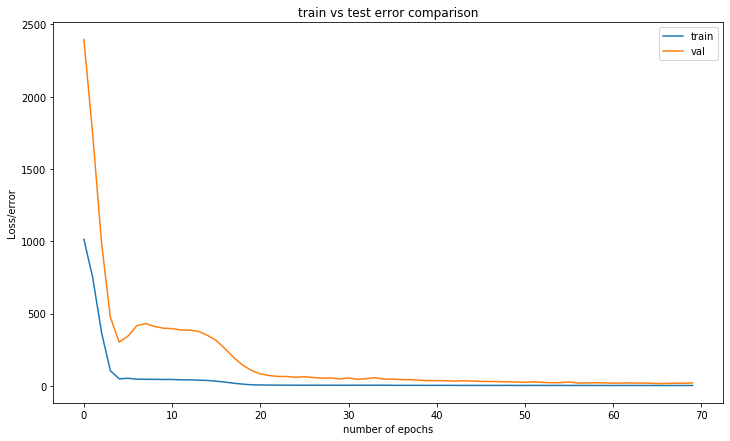

In [348]:
plt.plot(results.history['mean_squared_error'])
plt.plot(results.history['val_mean_squared_error'])
plt.title('train vs test error comparison')
plt.xlabel('number of epochs')
plt.ylabel('Loss/error')
plt.legend(['train', 'val'])

In [361]:
testscore = model.evaluate(test_features, test_label, verbose=0)

In [353]:
prediction= model.predict(test_features)

### Comparison actual vs prediction

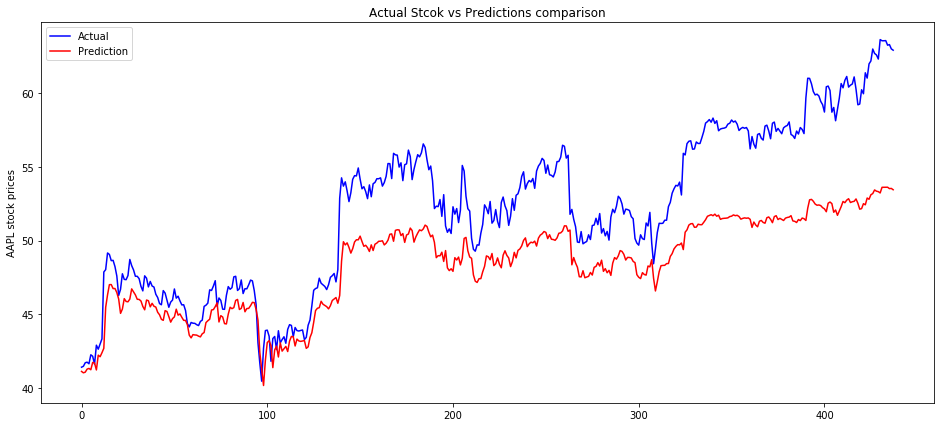

In [359]:
plt.rcParams["figure.figsize"] = (16, 7)
plt.plot(test_label, 'b')
plt.plot(prediction, 'r')
plt.ylabel('AAPL stock prices')
plt.title("Actual Stcok vs Predictions comparison")
plt.legend(['Actual', 'Prediction'])
plt.show()